# Clustering Case Study: Customer Segmentation with K-Means -  Tier 3
* Notebook coded and completed by Adam Lang, Springboard Data Science Fellow
* Date: 5/7/2024
***
This case study is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by the `yhat` blog. Please feel free to refer to the post for additional information, and solutions.

Structure of the mini-project:

1. **Sourcing and loading**
    * Load the data
    * Explore the data


2. **Cleaning, transforming and visualizing**
    * Data Wrangling: Exercise Set 1
        - Creating a matrix with a binary indicator for whether they responded to a given offer
        - Ensure that in doing so, NAN values are dealt with appropriately
    

3. **Modelling**
    * K-Means clustering: Exercise Sets 2 and 3
        - Choosing K: The Elbow method
        - Choosing K: The Silhouette method
        - Choosing K: The Gap statistic method
    
    * Visualizing clusters with PCA: Exercise Sets 4 and 5


4. **Conclusions and next steps**
    * Conclusions
    * Other clustering algorithms (Exercise Set 6)

In [1]:
# import libraries
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib

# ignore warnings output
import warnings
warnings.filterwarnings("ignore")

# Setup Seaborn
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

## 1. Sourcing and loading
### 1a. Load the data
The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [2]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
## data path in google drive
data_path = '/content/drive/MyDrive/Springboard_Data_Science/Unsupervised Learning/1602764303_Clustering_Case_Study_updated_10_15_2020/WineKMC.xlsx'

In [4]:
# read excel file - sheet 0
df_offers = pd.read_excel(data_path, sheet_name=0)

In [5]:
# df head
df_offers.head()

,Offer #,Campaign,Varietal,Minimum Qty (kg),Discount (%),Origin,Past Peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


In [6]:
# df info
df_offers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Offer #           32 non-null     int64 
 1   Campaign          32 non-null     object
 2   Varietal          32 non-null     object
 3   Minimum Qty (kg)  32 non-null     int64 
 4   Discount (%)      32 non-null     int64 
 5   Origin            32 non-null     object
 6   Past Peak         32 non-null     bool  
dtypes: bool(1), int64(3), object(3)
memory usage: 1.7+ KB


In [7]:
# df columns
df_offers.columns

Index(['Offer #', 'Campaign', 'Varietal', 'Minimum Qty (kg)', 'Discount (%)',
       'Origin', 'Past Peak'],
      dtype='object')

Summary:
* We are going to reformat the column names going forward to make data manipulation easier.

### 1b. Explore the data

In [8]:
# reformat the column names
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]

# check output
df_offers.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [9]:
# upload the 2nd dataset from 2nd excel worksheet
df_transactions = pd.read_excel(data_path, sheet_name=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


## 2. Cleaning, transforming and visualizing
### 2a. Data Wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>
</div>

In [10]:
#your turn
merged_df = df_transactions.merge(df_offers,how='left', left_on='offer_id',right_on='offer_id')

# new df head
merged_df.head()

,customer_name,offer_id,n,campaign,varietal,min_qty,discount,origin,past_peak
0,Smith,2,1,January,Pinot Noir,72,17,France,False
1,Smith,24,1,September,Pinot Noir,6,34,Italy,False
2,Johnson,17,1,July,Pinot Noir,12,47,Germany,False
3,Johnson,24,1,September,Pinot Noir,6,34,Italy,False
4,Johnson,26,1,October,Pinot Noir,144,83,Australia,False


In [11]:
## make a pivot table
pivot_df = pd.pivot_table(merged_df, values='n', index=['customer_name'], columns=['offer_id'], fill_value=0)

# reset the index
#pivot_df.reset_index(inplace=True)

#print df head
pivot_df.head()


offer_id,1,2,3,4,5,6,7,8,9,10,...,23,24,25,26,27,28,29,30,31,32
customer_name,,,,,,,,,,,,,,,,,,,,,
Adams,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
Allen,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
Anderson,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
Bailey,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
Baker,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0


In [12]:
print(pivot_df.index)

Index(['Adams', 'Allen', 'Anderson', 'Bailey', 'Baker', 'Barnes', 'Bell',
       'Bennett', 'Brooks', 'Brown', 'Butler', 'Campbell', 'Carter', 'Clark',
       'Collins', 'Cook', 'Cooper', 'Cox', 'Cruz', 'Davis', 'Diaz', 'Edwards',
       'Evans', 'Fisher', 'Flores', 'Foster', 'Garcia', 'Gomez', 'Gonzalez',
       'Gray', 'Green', 'Gutierrez', 'Hall', 'Harris', 'Hernandez', 'Hill',
       'Howard', 'Hughes', 'Jackson', 'James', 'Jenkins', 'Johnson', 'Jones',
       'Kelly', 'King', 'Lee', 'Lewis', 'Long', 'Lopez', 'Martin', 'Martinez',
       'Miller', 'Mitchell', 'Moore', 'Morales', 'Morgan', 'Morris', 'Murphy',
       'Myers', 'Nelson', 'Nguyen', 'Ortiz', 'Parker', 'Perez', 'Perry',
       'Peterson', 'Phillips', 'Powell', 'Price', 'Ramirez', 'Reed', 'Reyes',
       'Richardson', 'Rivera', 'Roberts', 'Robinson', 'Rodriguez', 'Rogers',
       'Ross', 'Russell', 'Sanchez', 'Sanders', 'Scott', 'Smith', 'Stewart',
       'Sullivan', 'Taylor', 'Thomas', 'Thompson', 'Torres', 'Turner',
    

In [13]:
# print shape
print(pivot_df.shape)

(100, 32)


## 3. Modelling
### 3a. K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

#### 3ai. Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned.

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly.

**Hint:** the Elbow Method is discussed in part 2 of the Harvard Clustering lecture.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<p><b>Exercise:</b></p>
<ul>
<li> What values of $SS$ do you believe represent better clusterings? Why?
<li> Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums)
<li> Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix.
<li> Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
<li> Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
<li> What challenges did you experience using the Elbow method to pick $K$?
</ul>
</div>

In [14]:
print(pivot_df.columns)

Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32],
      dtype='int64', name='offer_id')


In [15]:
# your turn
import sklearn.cluster
import numpy as np

# create empty list to store SS
ss = []

# create emtpy dict called assignments
assignments = {}

# Create a numpy matrix `x_cols` with only the columns
#representing the offers (i.e. the 0/1 colums)
x_cols = pivot_df.to_numpy()
print(f"dtype of x_cols is: {type(x_cols)}")

# print x_cols
x_cols

dtype of x_cols is: <class 'numpy.ndarray'>


array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 1]])

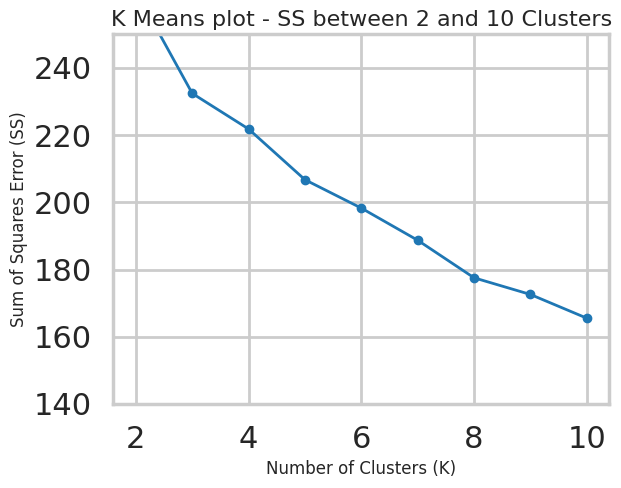

In [16]:
# Make a variable called Krange, and assign it a list of range(2, 11)
from sklearn.cluster import KMeans
Krange  = list(range(2, 11))

# We now want to iterate through this list to construct a plot showing SS for each K. Name the iterator variable K
for K in Krange:
    # Make a variable called model, and assign it the result of calling sklearn.cluster.KMeans, with n_clusters = K
    model = KMeans(n_clusters=K,random_state=42,n_init="auto")
    assigned_cluster = model.fit_predict(x_cols)
    centers = model.cluster_centers_
    ss.append(np.sum((x_cols - centers[assigned_cluster]) ** 2))
    assignments[str(K)] = assigned_cluster

# Construct a plot showing  SS  for each  K  and pick  K  using this plot. For simplicity, test  2≤K≤10 .
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(Krange, ss,linewidth=2,marker=".")
ax.set_ylim(140,250)
# Let's label the plot
plt.xlabel("Number of Clusters (K)",fontsize=12)
plt.ylabel("Sum of Squares Error (SS)",fontsize=12)
plt.title("K Means plot - SS between 2 and 10 Clusters",fontsize=16)
plt.show();

## Another Elbow Method - using the Python Yellowbrick API
* We will try a few of the methods from the Yellowbrick API to better visualize the elbow method.
* Documentation: https://www.scikit-yb.org/en/latest/api/cluster/elbow.html

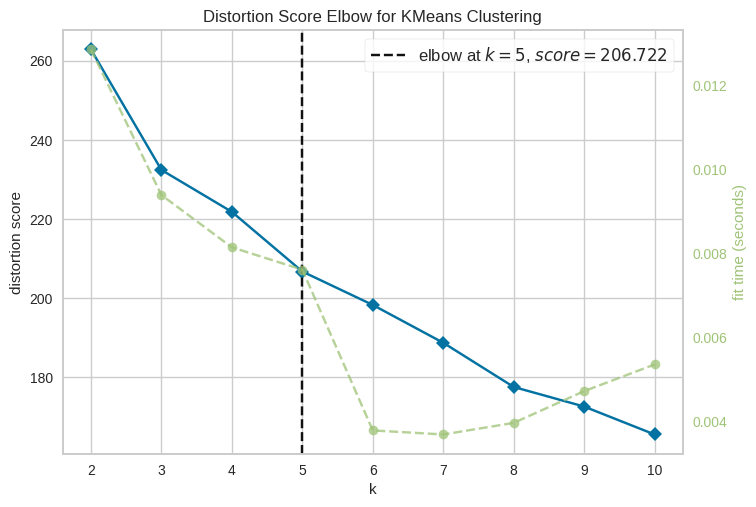

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [18]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer


# Instantiate the clustering model and visualizer
# model = KMeans()
# use the same model from above
visualizer = KElbowVisualizer(model, k=(2,11))

visualizer.fit(x_cols)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

Summary of the `KElbowVisualizer`:
* It appears the best K elbow is at 5 validated by this method.

## What values of SS  do you believe represent better clusterings? Why?
* The lower the SS the better the fit of the data, however the number of clusters increases as the SS gets smaller so we need to find the most optimal K where there are not too many clusters as we don't want the data points within each cluster to become to sparse or separated.
* The elbow Method is a technique that we use to determine the number of centroids(k) to use in a k-means clustering algorithm.  
* In this method to determine the k-value we iterate continuously for k=1 to k=n For every value of k, we calculate the within-cluster sum of squares (WCSS) value.
  * The WCSS is defined as the sum of square distances between the centroids and each points.
* When k=1 the WCSS has the highest value but with **increasing k value WCSS value starts to decrease.**
  * We must choose the value of k from where the graph starts to look like a straight line.
* Based on our plot we can say the **optimal K value appears to be 4 or 5** but it could also be 8 because that is where the plot starts to show a straight line. This illustrates why the elbow method has its drawbacks and is highly subjective.

## Make a bar chart showing the number of points in each cluster for k-means under the best  K .
  * What challenges did you experience using the Elbow method to pick  K ?

6


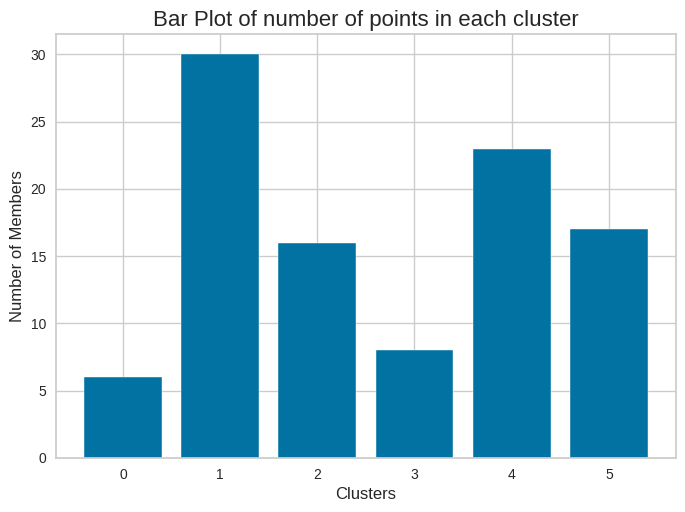

In [19]:
# What is the best K? Fill in the assignment below appropriately
best_K = 6 #Note --> The best K is 4 or 5, but to use the range(best_K) in the plot below I want to see what 4 actually is
assignments_best_K = assignments[str(best_K)]
counts = np.bincount(assignments_best_K)
print(len(counts))

# Call bar() on plt, with parameters range(best_K), counts, and align = 'center'
plt.bar(range(best_K), counts, align='center')


# Label the axes
plt.xlabel("Clusters",fontsize=12)
plt.ylabel("Number of Members",fontsize=12)
plt.xticks(range(best_K))
plt.title("Bar Plot of number of points in each cluster",fontsize=16)
plt.show();

Summary of plot
* The elbow method suggested the a K of 4 or 5 would be optimal. We can see based on the number of clusters above with the number of members, that a K of 4 has the 2nd most number of members and a K of 5 has the 3rd most number of members. While we can rely on the visual aspect of the elbow method, we really need to explore the optimal K that gives us the minimal sum of squares with the most points in that cluster that are closely related.

## Between Cluster sum of Squares vs. Within Cluster Sum of Squares
* I was curious about this so I wanted to try and calculate and plot this with our data.

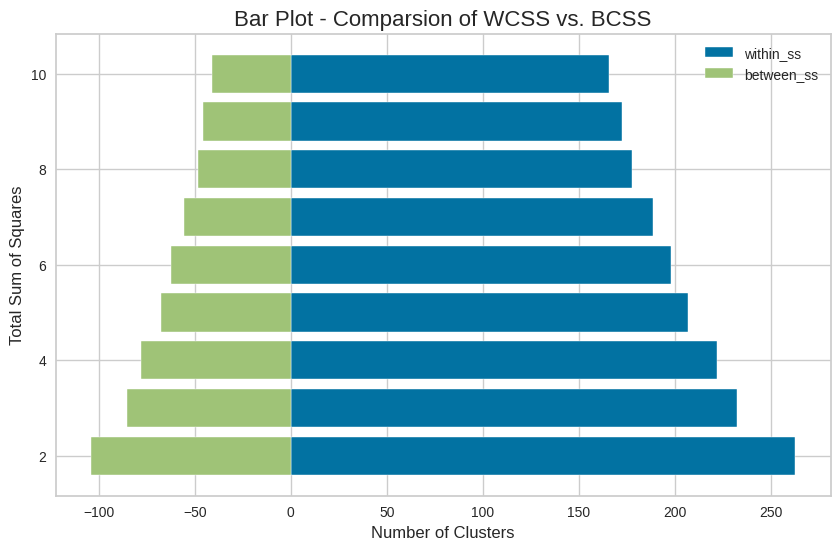

In [20]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

k_values = []
within_ss = []
between_ss = []

for k in Krange:
    kmeans = KMeans(n_clusters=k, random_state=42,n_init='auto').fit(x_cols)
    within_ss.append(kmeans.inertia_)
    between_ss.append(sum(np.min(cdist(x_cols, kmeans.cluster_centers_, 'euclidean'), axis=1)) - kmeans.inertia_)
    k_values.append(k)


ssc = pd.DataFrame({
    'kmeans': k_values,
    'within_ss': within_ss,
    'between_ss': between_ss
})

ssc_melted = ssc.melt(id_vars='kmeans', var_name='measurement', value_name='value')


plt.figure(figsize=(10, 6))
for measurement in ['within_ss', 'between_ss']:
  plt.barh(ssc_melted['kmeans'][ssc_melted['measurement'] == measurement],
          ssc_melted['value'][ssc_melted['measurement'] == measurement],
          label=measurement)
plt.xlabel('Number of Clusters',fontsize=12)
plt.ylabel('Total Sum of Squares',fontsize=12)
plt.title('Bar Plot - Comparsion of WCSS vs. BCSS',fontsize=16)
plt.legend()
plt.show();




Summary of the comparison plot and calculations
* If we wanted to maximize the between cluster sum of squares and minimize the within cluster sum of squares then it appears we would want to choose a K of 10. This is probably not accurate but something to consider as we now look at the Silhouette Method.

## Another Method to Calculate K: Calinski-Harabasz Index
* The Calinski-Harabasz index also known as the Variance Ratio Criterion, is the ratio of the sum of between-clusters dispersion and of inter-cluster dispersion for all clusters, the higher the score , the better the performances.
* Advantages
  * Score is higher when clusters are dense and well separated, which relates to a standard concept of a cluster.
  * Fast to compute.
* Drawbacks
  * The Calinski-Harabasz index is generally higher for convex clusters than other concepts of clusters, such as density based clusters like those obtained through DBSCAN.
  * Source: https://medium.com/@haataa/how-to-measure-clustering-performances-when-there-are-no-ground-truth-db027e9a871c
* We will use the Yellowbrick API to do this.

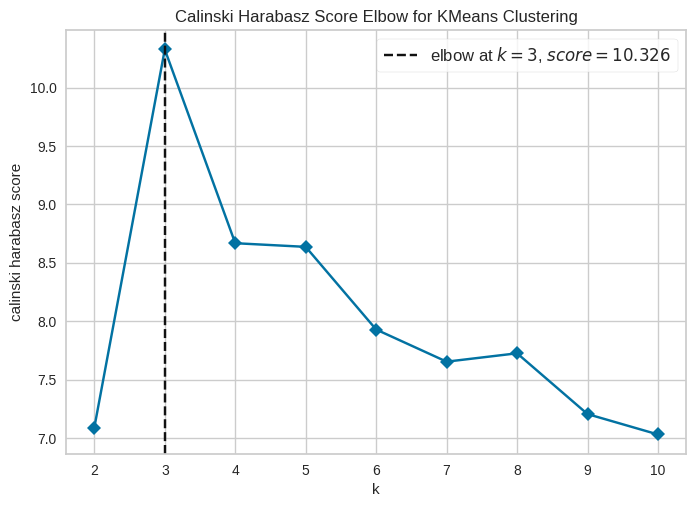

<Axes: title={'center': 'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [22]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer


# Instantiate the clustering model and visualizer
# model = KMeans() --> use same KMeans model above
visualizer = KElbowVisualizer(
    model, k=(2,11), metric='calinski_harabasz', timings=False
)

visualizer.fit(x_cols)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

## Summary:
* **The Calinski Harabasz score was 10 and the elbow is predicted at 3. A K of 3 is not too far off from the K of 4 or 5 predicted in the KMeans models above.**
* This is also called the "Knee point detection" algorithm. This is also called the "kneedle algorithm". The concept is that given 2 points x and y the algorithm will find the maximal curvature.
    * Original paper: https://raghavan.usc.edu//papers/kneedle-simplex11.pdf
    * Github: https://github.com/arvkevi/kneed

#### 3aii. Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

**Hint**: Scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>
</div>

For n_clusters = 2 The average silhouette_score is : 0.09174871508750351
For n_clusters = 3 The average silhouette_score is : 0.12078917343046144
For n_clusters = 4 The average silhouette_score is : 0.10574609278168547
For n_clusters = 5 The average silhouette_score is : 0.10519480826686786
For n_clusters = 6 The average silhouette_score is : 0.13313126627114877
For n_clusters = 7 The average silhouette_score is : 0.12744004672000728
For n_clusters = 8 The average silhouette_score is : 0.11959919678519433
For n_clusters = 9 The average silhouette_score is : 0.13960449910180658
For n_clusters = 10 The average silhouette_score is : 0.12842271634093724


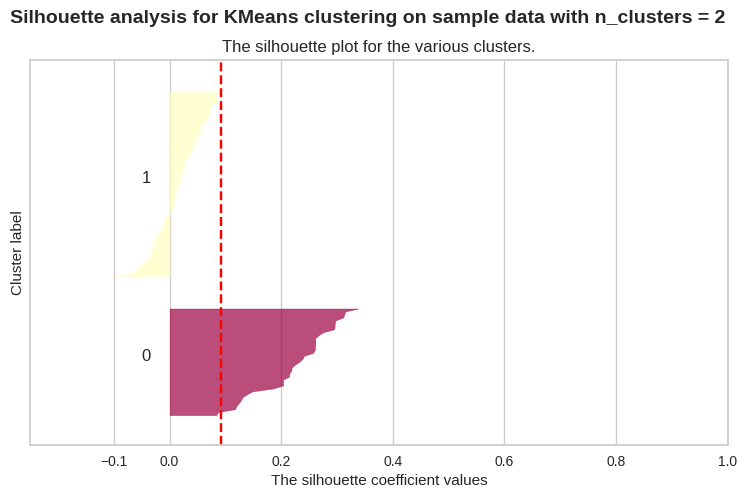

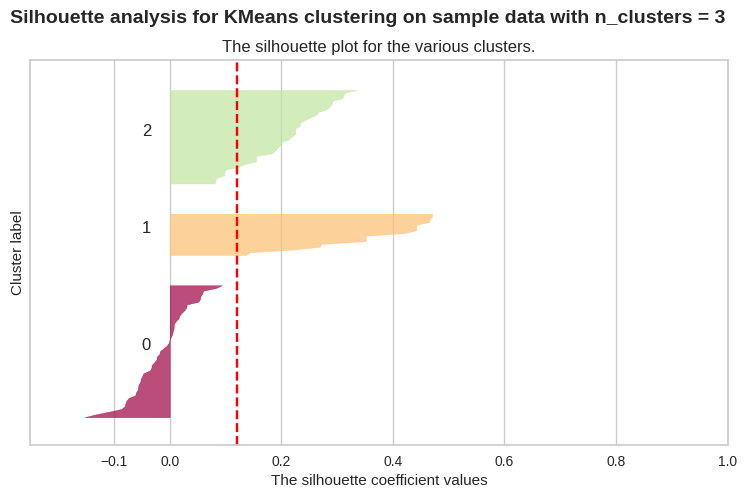

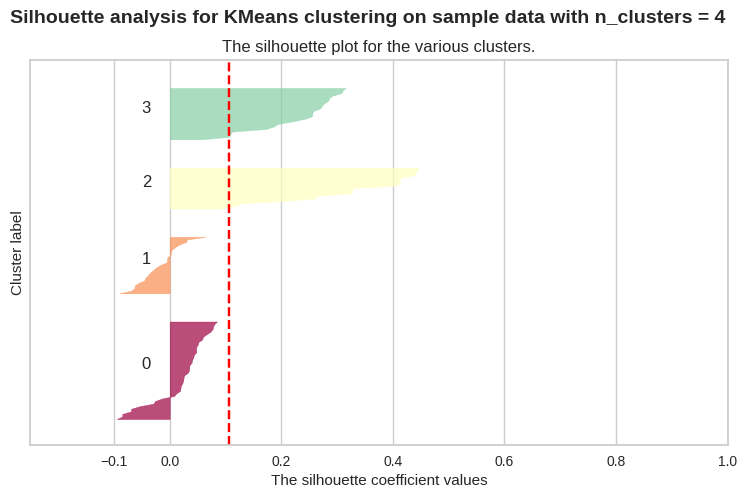

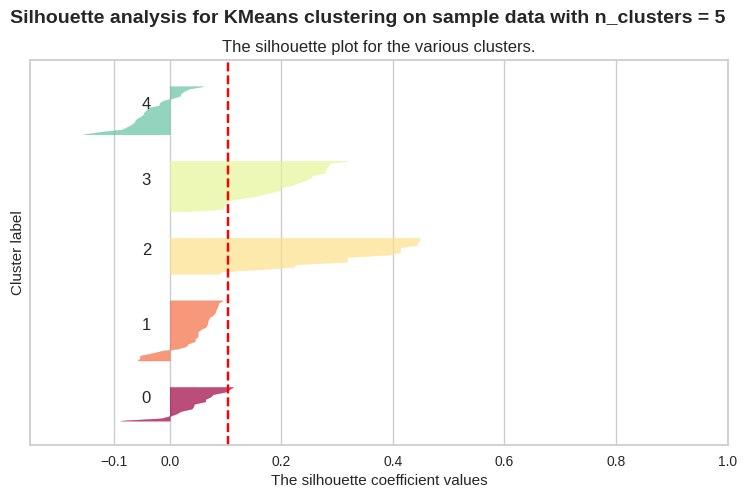

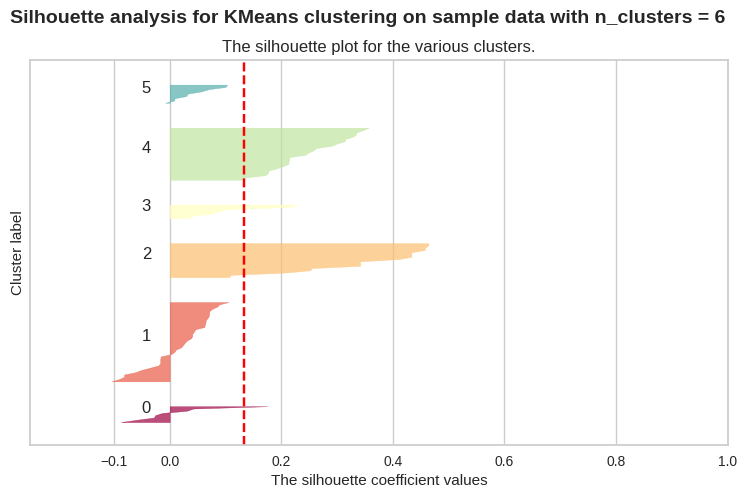

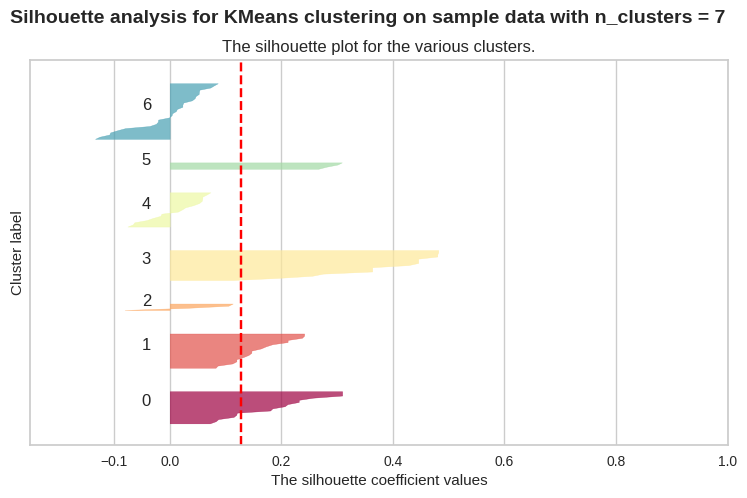

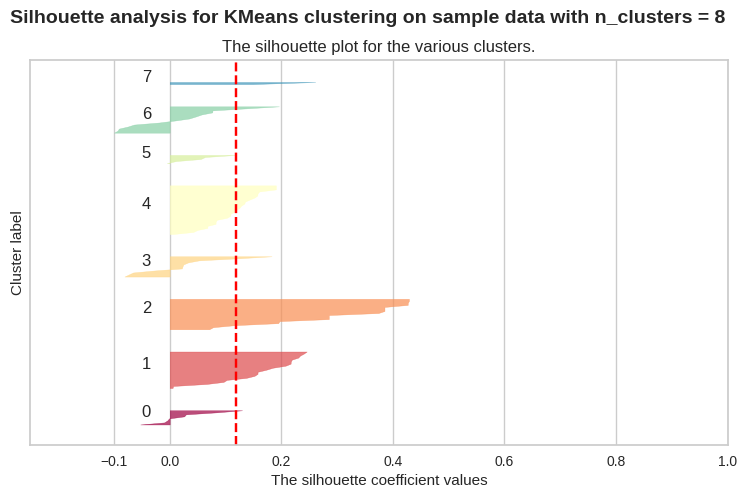

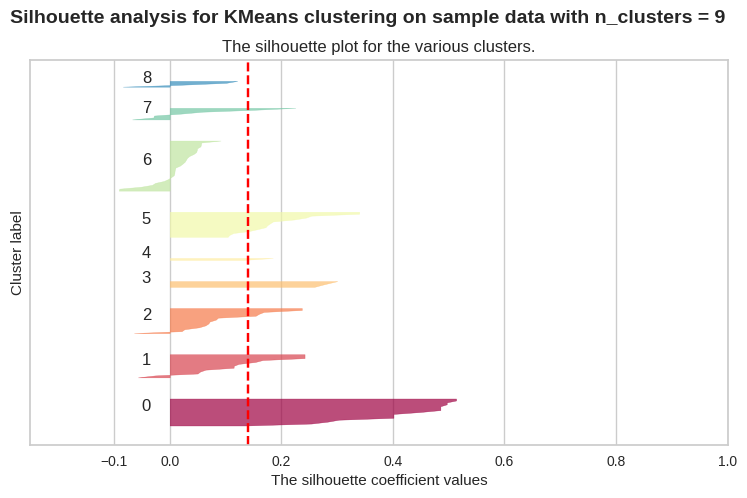

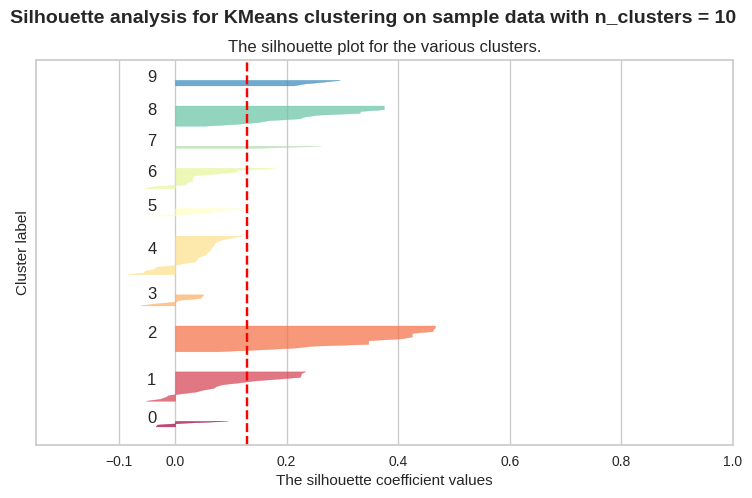

In [23]:
# import libraries
import warnings
import sklearn.metrics
import matplotlib.cm as cm

# supress warnings
warnings.filterwarnings('ignore')

# Make an empty list called avg_silhouette_scores
avg_silhouette_scores = []

# Iterate through Krange with variable K as before
for K in Krange:
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(9, 5)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    # Call set_xlim on ax1
    ax1.set_xlim([-0.25, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(x_cols) + (K + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = sklearn.cluster.KMeans(n_clusters=K, random_state=42)
    cluster_labels = clusterer.fit_predict(x_cols)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    # Make a variable called silhouette_avg. Set the parameters to silhouette_score to X, and cluster_labels
    silhouette_avg  = sklearn.metrics.silhouette_score(x_cols, cluster_labels)
    avg_silhouette_scores.append(silhouette_avg)
    print("For n_clusters =", K,
          "The average silhouette_score is :", silhouette_avg)


    # Compute the silhouette scores for each sample
    # Call sklearn.metrics.silhouette_samples with the below parameters
    sample_silhouette_values = sklearn.metrics.silhouette_samples(x_cols, cluster_labels)

    y_lower = 10
    for i in range(K):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        # Make a variable called ith_cluster_silhouette_values
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        # Call sort() on this variable
        ith_cluster_silhouette_values.sort()

        # Call shape[0] on ith_cluster_silhouette_values
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        cmap = cm.get_cmap('Spectral')
        color = cmap(float(i) / K)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        # This requires calling text() on ax1
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    # Setting title, xlabel and ylabel
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    # This requires axvline()
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % K),
                 fontsize=14, fontweight='bold')


plt.show();

## Exercise: Compute the average silhouette score for each  K  and plot it. What  K  does the plot suggest we should choose? Does it differ from what we found using the Elbow method?

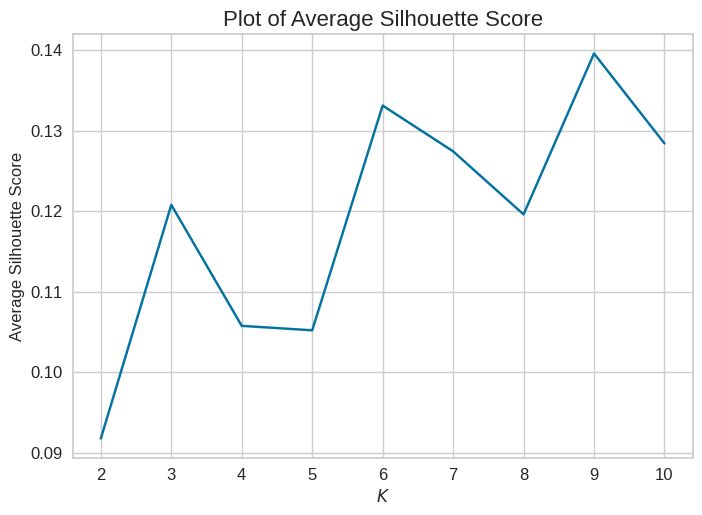

In [24]:
# Computing the avrage silhouette score for each K and plotting it
# Call plot() with parameters KRange, avg_silhouette_scores
plt.plot(range(2,11), avg_silhouette_scores,marker="x")
plt.xlabel("$K$",fontsize=12)
plt.ylabel("Average Silhouette Score",fontsize=12)
plt.title("Plot of Average Silhouette Score",fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show();

* For n_clusters = 2 The average silhouette_score is : 0.09174871508750351
* For n_clusters = 3 The average silhouette_score is : 0.12078917343046144
* For n_clusters = 4 The average silhouette_score is : 0.10574609278168547
* For n_clusters = 5 The average silhouette_score is : 0.10519480826686786
* For n_clusters = 6 The average silhouette_score is : 0.13313126627114877
* For n_clusters = 7 The average silhouette_score is : 0.12744004672000728
* For n_clusters = 8 The average silhouette_score is : 0.11959919678519433
* For n_clusters = 9 The average silhouette_score is : 0.13960449910180658
* For n_clusters = 10 The average silhouette_score is : 0.12842271634093724

## What can you conclude?
* The best value of K was 3 or 4 or 5 based on the elbow sum of squares method (depending on which method you consider I used 3 of them above).
*The silhouette method helps us to evaluate cohesion and separation of data points in a cluster and in comparison to other larger clusters in a vector space. An inlier is a data point more central to the other points in its own cluster, an outlier is a data point on the edge of a cluster. Another way to phrase this is the "cohesion" or closeness of data points in a cluster vs. the "separation" of data points in a cluster.
* "Inliers" or more "cohesion" of data points will have a silhouette score closer to 1.
* "Outliers" or more "separated" data points will have a silhouette score closer to 0 at the edge of the the cluster group.
* Negative silhouette scores are usually outliers.

**So what does this mean for our Silhouette data?**

* The plot above shows us that generally speaking, a **K value of 9 will have data points that are more closer to 1 and more similar with more cohesion.** The K values of 10, 8, and 6 are the next most highets silhouette scores and every other data point in other clusters would have less cohesion and more separation.
* So based on the plot above, choosing a value of **K of 9 would be optimal.** **However, based on the standard ranges for silhouette scores, the average scores for the K values here are all below 0.25 which means no substantial structure has been found which means as a whole, the average data point in each k cluster is more likely to be on the edge of each cluster with more separation and less cohesion**
* So in summary, right now it seems that a K of 9 is best based on the silhohette method which is more precise in calculation. And the between cluster sum of squares max and the within cluster sum of squares min of 10 seems within range of this, however, the elbow method with the K of 4 or 5 also seems optimal. We should consider that the more clusters we add the less cohesion we may encounter in the data points and more separation.

#### 3aiii.  Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

#### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

**Hint:** See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

### 3b. Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

**Hint:** PCA was discussed in the previous subunit. If you need help with it, consult [this useful article](https://towardsdatascience.com/a-one-stop-shop-for-principal-component-analysis-5582fb7e0a9c) and [this visual explanation](http://setosa.io/ev/principal-component-analysis/).

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
<li> Plot a scatterplot of the `x` vs `y` columns
<li> Color-code points differently based on cluster ID
<li> How do the clusters look?
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
</ul>

<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p>
</div>

In [25]:
#sklearn use PCA to reduce dimensionality
import numpy as np
from sklearn.decomposition import PCA

# Create PCA with 2 components
pca = PCA(n_components=2)

# fit PCA to dataset
pca.fit(x_cols)

# transform dataset using PCA
pca_features = pca.transform(x_cols)

# print pca_features
print(pca_features)

# print shape of pca_features
print(f"The shape of pca_features is: {pca_features.shape}")

[[ 1.00757996e+00  1.08214665e-01]
 [-2.87539237e-01  4.47145141e-02]
 [-3.92032043e-01  1.03839141e+00]
 [ 6.99477269e-01 -2.25422232e-02]
 [ 8.81832248e-02 -4.71695431e-01]
 [-4.85281909e-01 -7.25503292e-01]
 [-5.91940987e-01  1.50649994e+00]
 [ 6.61731534e-01  9.03075520e-02]
 [-1.18943267e-01 -5.77498507e-01]
 [ 1.07982739e+00 -7.48818111e-03]
 [-2.40431061e-01 -6.17026041e-01]
 [-5.22247106e-01  1.23140642e+00]
 [ 1.26076270e+00 -1.42550704e-02]
 [-5.79220584e-01 -4.20474690e-01]
 [ 1.93998464e-01  1.03057282e-02]
 [-3.92032043e-01  1.03839141e+00]
 [-4.06275667e-01 -4.57711391e-02]
 [-5.91940987e-01  1.50649994e+00]
 [ 7.36154519e-01  1.17752476e-01]
 [-3.49056937e-01 -2.67081210e-01]
 [ 1.41224694e+00 -1.23874426e-01]
 [ 1.81048277e-01 -2.06529405e-02]
 [-3.71484955e-01 -3.48006774e-01]
 [-5.09136903e-01 -6.87321373e-01]
 [-2.39706096e-01  9.11843998e-01]
 [-7.82355465e-01 -5.18475045e-01]
 [-2.99665902e-01  6.96444453e-03]
 [-4.12829546e-01 -1.21989471e-02]
 [-3.39145922e-01 -1

In [26]:
pivot_df.columns

Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32],
      dtype='int64', name='offer_id')

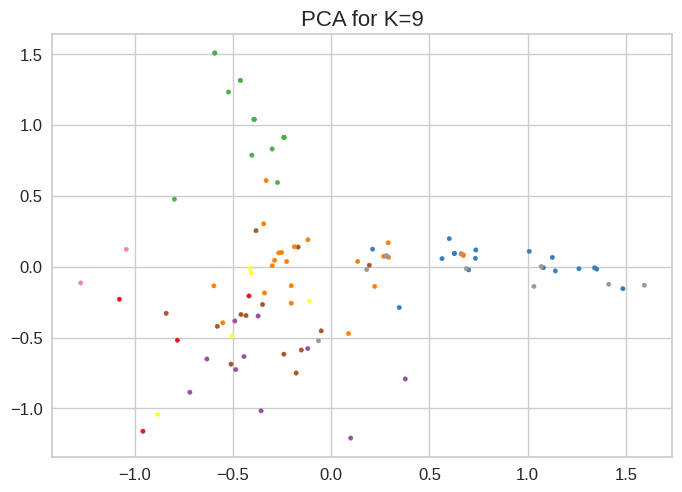

In [27]:
## Pass two PCA components (label them `x` and `y`)
x, y = zip(*pca_features)


# obtain clusters for n_clusters=8 based on silhouette plot above
clusters = KMeans(n_clusters=9, random_state=42,n_init='auto')
## add new column to original pivot_df
pivot_df['Cluster_9'] = clusters.fit_predict(x_cols)


# now add the customer name, x and y PCA components to the pivot_df
pivot_df['x'] = x
pivot_df['y'] = y

# rearrange columns from original pivot_df
item_columns = [col for col in pivot_df.columns[:32]]
# drop the other columns in the original pivot_df
pivot_df = pivot_df.drop(item_columns,axis=1)


## plot scatterplot of x and y
plt.scatter(pivot_df['x'], pivot_df['y'], c = pivot_df['Cluster_9'],
            cmap='Set1', s=10)
plt.title("PCA for K=9",fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show();

Summary of PCA for K=9
* We can see that reducing our dimensions from 32 features to 2 based on the silhouette maximal value of K=9, it is very difficult to detect specific cluster groupings in this PCA plot. It might be best to try other values of K and not rely solely on the silhouette score.
* We should also remember that the PCA while a great algorithm for dimensionality reduction, it works well with linearly structured data because it is a linear technique that works best with data that has a linear structure to it. The goal of PCA is to identify the underlying principal components in the data by projecting onto lower dimensions, minimizing variance, and preserving large pairwise distances. If our the shape our data is not linear, then PCA may not be the best tool, but we can explore that idea further after we look at other K values in PCA.
  * source: https://www.datacamp.com/tutorial/introduction-t-sne

In [28]:
# create a copy of the new pivot_df without Cluster_9
df = pivot_df.drop(['Cluster_9'],axis=1).copy()
df.head()

offer_id,x,y
customer_name,,
Adams,1.007580,0.108215
Allen,-0.287539,0.044715
Anderson,-0.392032,1.038391
Bailey,0.699477,-0.022542
Baker,0.088183,-0.471695


In [29]:
# shape of this new df
df.shape

(100, 2)

In [30]:
## lets' get the K cluster predictions for the other K values
k_range = list(range(2,11))

# loop through k_range
for k in k_range:
  k_means_cluster = KMeans(n_clusters=k, random_state=42,n_init='auto')
  k_means_pred = k_means_cluster.fit_predict(x_cols)
  df['Cluster_' + str(k)] = k_means_pred

# new df
df.head()

offer_id,x,y,Cluster_2,Cluster_3,Cluster_4,Cluster_5,Cluster_6,Cluster_7,Cluster_8,Cluster_9,Cluster_10
customer_name,,,,,,,,,,,
Adams,1.007580,0.108215,1,1,1,4,4,4,1,1,1
Allen,-0.287539,0.044715,1,1,1,1,1,5,4,4,4
Anderson,-0.392032,1.038391,1,2,2,2,2,2,2,2,2
Bailey,0.699477,-0.022542,1,1,1,4,4,4,1,1,1
Baker,0.088183,-0.471695,1,1,1,1,1,3,4,4,4


### Plot PCA for the other K values

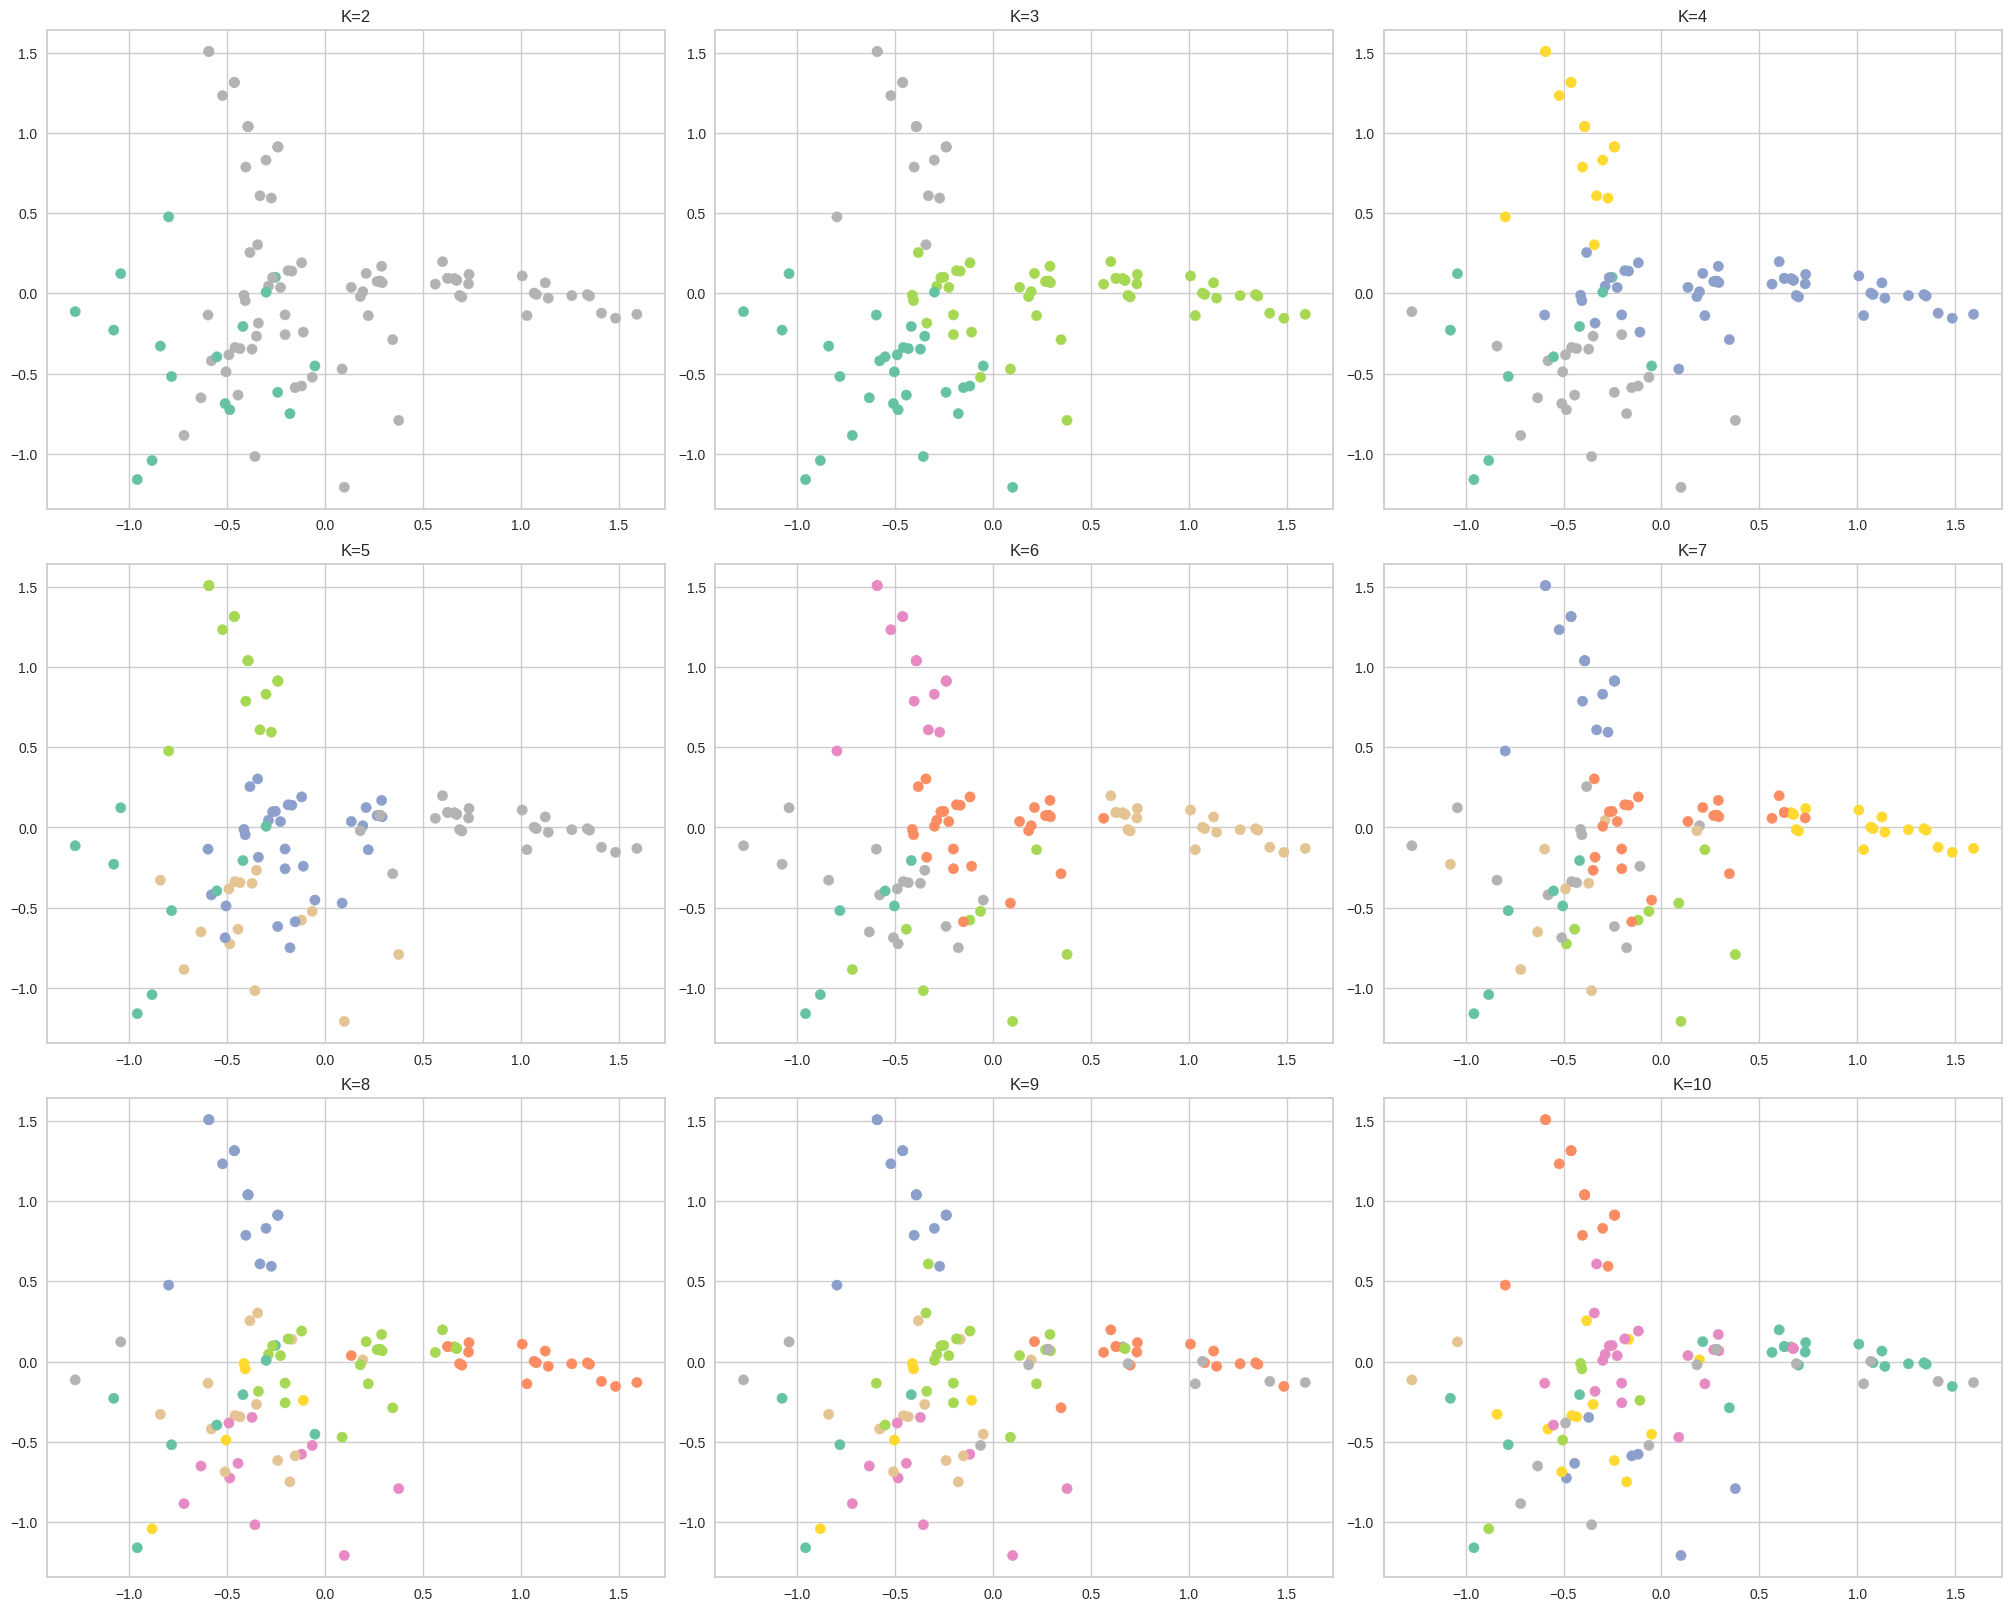

In [31]:
# subplots

# instaniate k_range again
k_range = list(range(2,11))

# length of an array
array_len = len(k_range)

# build subplots
fix, axes = plt.subplots(array_len//3 + array_len%3, 3,figsize=(20,16),layout='constrained')
fig.set_size_inches(20,18)
fig.subplots_adjust(top=1, wspace=0.5, hspace=0.5)


# loop through and plot
for idx, k in enumerate(k_range):
  x_axes = idx//3
  y_axes = idx%3

  axes[x_axes][y_axes].scatter(df['x'], df['y'], c=df['Cluster_'+str(k)], cmap='Set2', s=55)
  axes[x_axes][y_axes].set_title("K="+str(k),fontsize=12)


plt.show();


Summary of PCA Analysis
* It seems a K of 3 is the most optimal number of clusters. If you look at the PCA plot for K=3 we can see this exemplifies the best clustering of all offer_id classes with little to no overlap in the classes or misclassification of data points. We can also say that the clusters produced in the K=3 plot the data points are most cohesive with little separation.
* It is interesting that one of the methods we used above The Calinski-Harabasz index also known as the **Variance Ratio Criterion**, suggested a K of 3 was optimal. We should recall that this index is the ratio of the sum of between-clusters dispersion and of inter-cluster dispersion for all clusters, the higher the score , the better the performances. Since the PCA algorithms goals is to minimize variance and preserve large pairwise distances, it is interesting that considering the variance in both algorithms leads us to an optimal K of 3.
* **It is also worth noting that the "Variance Ratio Criterion" as well as other related methods have been studied and proven to be more successful than the standard elbow method of sum of squares.**
    * Source: https://arxiv.org/pdf/2212.12189
* The other K values there seems to be too much overlap in the clusters and definitely some misclassification.

What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.

## Exercise: Now look at both the original raw data about the offers and transactions and look at the fitted clusters.
  * Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?

In [32]:
# first reset the index on our df
df = df.reset_index(drop=False)


# utilize relevant columns from our analysis above
# Cluster_3 for K=3 and Cluster_9 for K=9 (silhouette score), and customer name
df_new = df[['customer_name','Cluster_3','Cluster_9']]


# merge df's
df_merge_final = pd.merge(df_new, merged_df, on='customer_name')


# view df_merge_final
df_merge_final.head()

,customer_name,Cluster_3,Cluster_9,offer_id,n,campaign,varietal,min_qty,discount,origin,past_peak
0,Adams,1,1,18,1,July,Espumante,6,50,Oregon,False
1,Adams,1,1,29,1,November,Pinot Grigio,6,87,France,False
2,Adams,1,1,30,1,December,Malbec,6,54,France,False
3,Allen,1,4,9,1,April,Chardonnay,144,57,Chile,False
4,Allen,1,4,27,1,October,Champagne,72,88,New Zealand,False


## Let's look at the Clusters and the variable 'Varietal'
* As we can see above, the 'varietal' variable is the variety or type of wine.

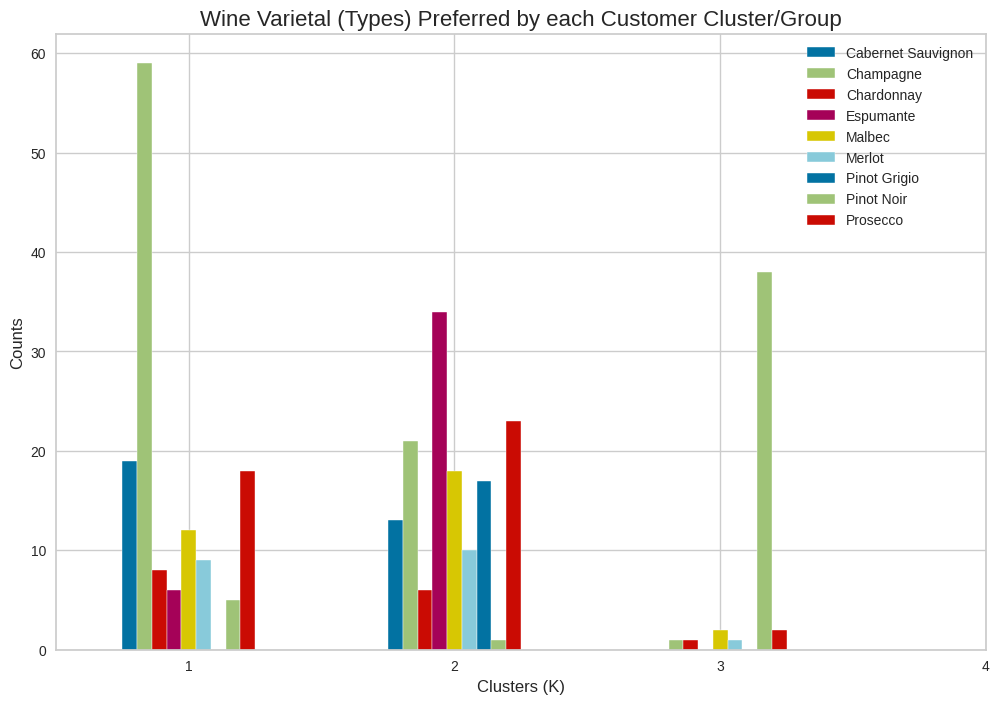

In [44]:
## lets use pd.crosstab
cross_tab = pd.crosstab(df_merge_final['Cluster_3'],df_merge_final['varietal'])


# Plot the data
cross_tab.plot(kind='bar', figsize=(12,8))
plt.xlabel('Clusters (K)',fontsize=12)
plt.ylabel('Counts',fontsize=12)
plt.title("Wine Varietal (Types) Preferred by each Customer Cluster/Group",fontsize=16)
plt.xticks(range(4),('1','2','3','4'),rotation=0)
plt.legend(loc='upper right',fancybox=True, shadow=True)
plt.show();

## Summary of Customer Clusters vs. Wine Varietal
* It appears that for Cluster or Group 3, that Pinot Noir was most popular by far well above the other types of wines.
* For Cluster or Group 2, it appears Espumante followed by Chardonnay were most popular.
* For Cluster or Group 1 again we can see that Pinot Noir was most popular, followed by Cabernet Sauvignon and Chardonnay.
* Based on this analysis we could assume that Pinot Noir is most popular followed by Chardonnay.

## Let's look at Wine Origin by Customer Group

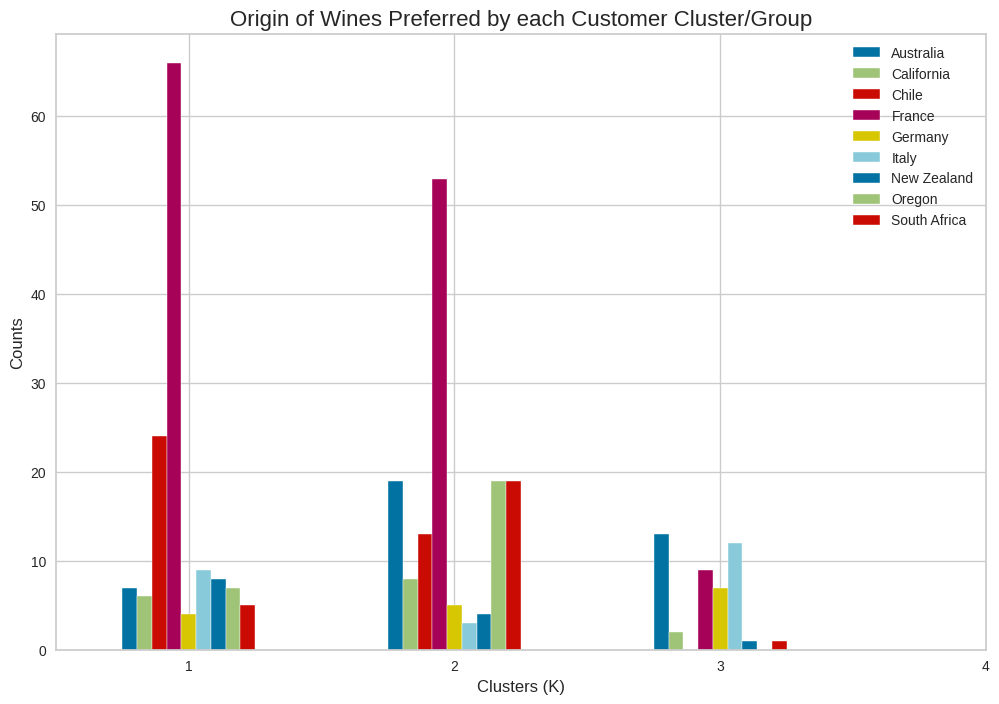

In [45]:
## lets use pd.crosstab
cross_tab = pd.crosstab(df_merge_final['Cluster_3'],df_merge_final['origin'])


# Plot the data
cross_tab.plot(kind='bar', figsize=(12,8))
plt.xlabel('Clusters (K)',fontsize=12)
plt.ylabel('Counts',fontsize=12)
plt.title("Origin of Wines Preferred by each Customer Cluster/Group",fontsize=16)
plt.xticks(range(4),('1','2','3','4'),rotation=0)
plt.legend(loc='upper right',fancybox=True, shadow=True)
plt.show();

## Summary of Wine Origin by Customer Group
* It appears that Customer Group 1 strongly preferred French wine as well as Customer Group 2. Both Group 1 and 2 also preferred Chilean wine as the 2nd preference.
* The 3rd cluster that led the way in the previous analysis with Pino Noir, did not have a strong preference for region but it was close between New Zealand, Italy, and France.
* We could make the assumption based on this analysis that French wine is most popular.

<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>
</div>

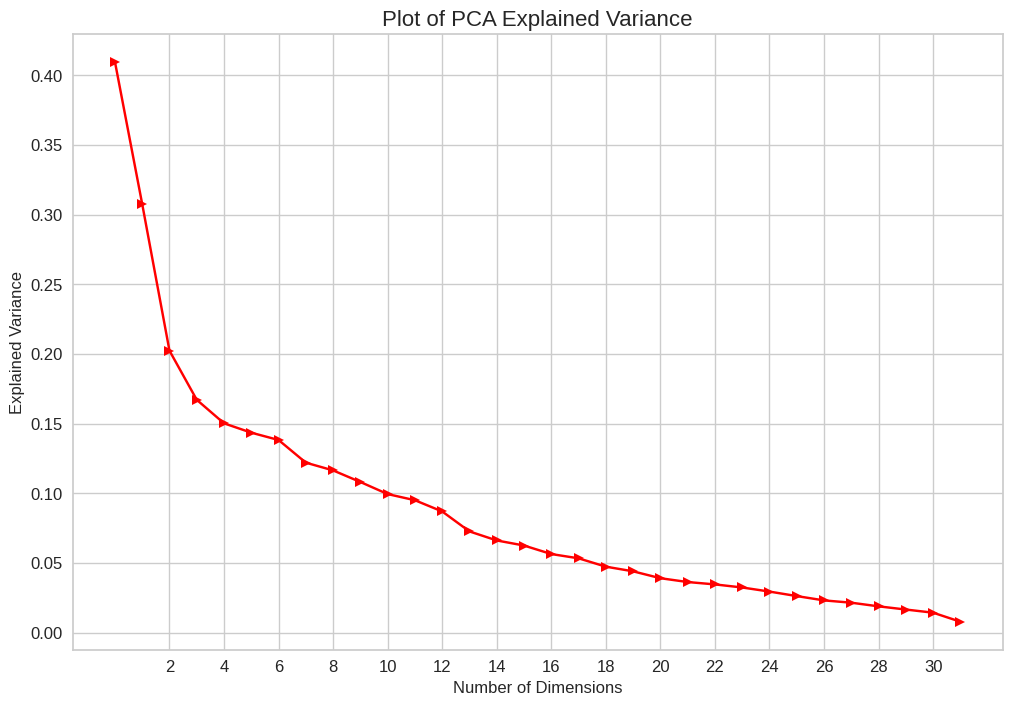

In [52]:
#your turn
# Initialize a new PCA model with a default number of components.
import sklearn.decomposition
pca = sklearn.decomposition.PCA()
pca.fit(x_cols)

# Do the rest on your own :)
plt.figure(figsize=(12,8))
plt.plot(pca.explained_variance_,marker=">",color='red')
plt.xlabel('Number of Dimensions',fontsize=12)
plt.ylabel('Explained Variance',fontsize=12)
plt.xticks(range(2,32,2),fontsize=12)
plt.yticks(fontsize=12)
plt.title("Plot of PCA Explained Variance",fontsize=16)
plt.show();


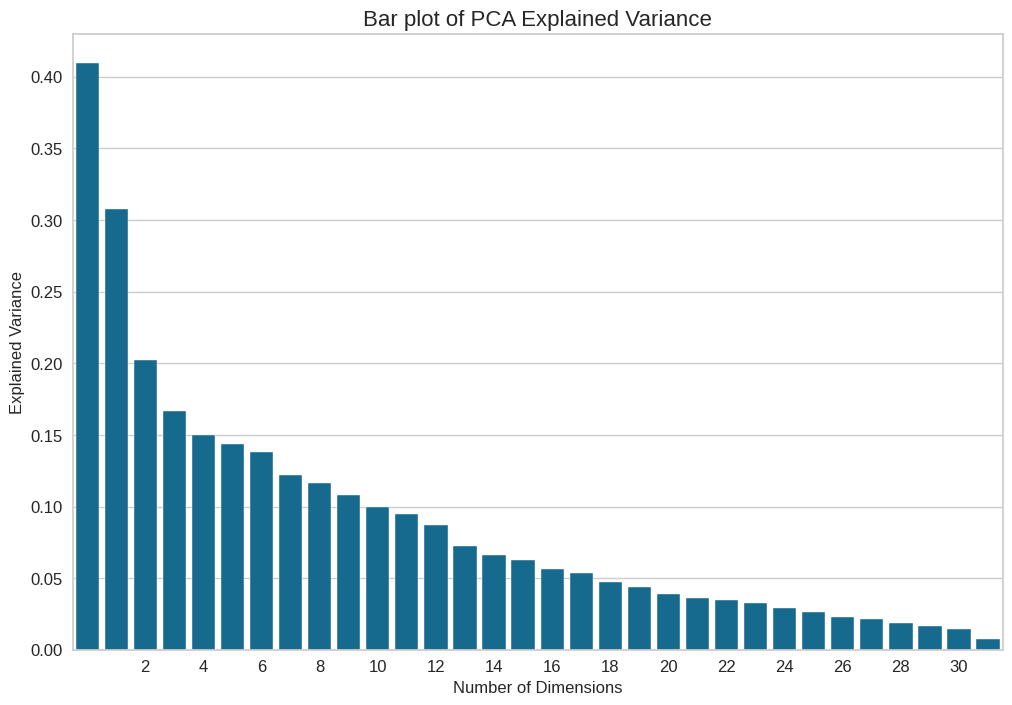

In [57]:
## Let's make a barplot
plt.figure(figsize=(12,8))
features = range(pca.n_components_)
sns.barplot(x=features,y=pca.explained_variance_)
plt.xlabel('Number of Dimensions',fontsize=12)
plt.ylabel('Explained Variance',fontsize=12)
plt.xticks(range(2,32,2),fontsize=12)
plt.yticks(fontsize=12)
plt.title("Bar plot of PCA Explained Variance",fontsize=16)
plt.show();

## Summary
* We can see based on the 2 explained variance plots that between 2 and 3 dimensions is where there is a significant drop off in the explained variance that slowly drops to 0 by the last feature dimension.
* Thus we can confirm that 3 is the optimal number of dimensions for our data.

## 4. Conclusions and next steps
### 4a. Conclusions
What can you conclude from your investigations? Make a note, formulate it as clearly as possible, and be prepared to discuss it with your mentor in your next call.

### 4b. Other clustering algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn.

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity.

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p>How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>
</div>


In [72]:
# Your turn
# Initialize an empty dictionary to convert to dataframe later
cluster_dict = {}

# 1. Affinity Propagation
* This method is "based on “message passing" between data points represented as connected nodes on a bipartite graph, in which edges represent the similarity between pairs of points."
* The main advantages is that, unlike other clustering algorithms such as K-Means or K-Medoids, it does not require the number of clusters to be determined prior to modeling since they are formed around exemplary nodes, namely exemplars, which are representative nodes of the clusters (Castano et al. arXiv:2401.14439v1 [cs.LG] 25 Jan 2024).
* The entire concept of this algorithm is the idea that the graph algorithm lets the data points "vote" on their preferred "exemplar" cluster or "best cluster".
* The main params to tune is the "damping" set between 0.5 and 1 and "preference". Source: Brownlee, 2020. "10 Clustering Algorithms With Python". Retrieved from: https://machinelearningmastery.com/clustering-algorithms-with-python/


In [73]:
from sklearn.cluster import AffinityPropagation

# Hyperparameter Tuning
damping_list = np.linspace(0.5, 1, 10, endpoint=False)   # returns 10 values between 0.5 <= x < 1

best_score = 0

for d in damping_list:
    affinity = AffinityPropagation(damping=d)
    ap_cluster = affinity.fit_predict(x_cols)
    sil_avg_score = sklearn.metrics.silhouette_score(x_cols, ap_cluster, random_state = 42)

    print("For damping value of: {:0.2f}, the silhouette score is: {:0.3f}".format(d, sil_avg_score))
    if sil_avg_score > best_score:
        best_score = sil_avg_score  # Update with the best silhouette score
        best_damping = d

print("\nBest damping hyperparameter is: {:0.2f}, with a silhouette score of: {:0.3f}".format(best_damping, best_score))
# append the silhouette scores to the final dictionary
cluster_dict["Affinity"] = best_score

For damping value of: 0.50, the silhouette score is: 0.124
For damping value of: 0.55, the silhouette score is: 0.123
For damping value of: 0.60, the silhouette score is: 0.124
For damping value of: 0.65, the silhouette score is: 0.126
For damping value of: 0.70, the silhouette score is: 0.122
For damping value of: 0.75, the silhouette score is: 0.124
For damping value of: 0.80, the silhouette score is: 0.085
For damping value of: 0.85, the silhouette score is: 0.106
For damping value of: 0.90, the silhouette score is: 0.083
For damping value of: 0.95, the silhouette score is: 0.114

Best damping hyperparameter is: 0.65, with a silhouette score of: 0.126


In [65]:
af = AffinityPropagation(damping = 0.5).fit(x_cols)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_
df['Cluster'] = labels
n_clusters_ = len(cluster_centers_indices)

print('Estimated number of clusters: {}'.format(n_clusters_))

sil_score = sklearn.metrics.silhouette_score(x_cols, labels, metric='sqeuclidean')
print('Silhouette Score: {}'.format(sil_score))


Estimated number of clusters: 14
Silhouette Score: 0.18563670773763985


Summary:
* We can see that for Affinity Propagation a silhouette score of 0.126 is optimal with a damping of 0.65 and a silhouette score of 0.185 is best with 14 clusters.

#2. Spectral Clustering
* For this clustering technique, data points are treated as nodes of a graph. Thus, spectral clustering is a graph partitioning problem.
* Nodes are then mapped to a lower-dimensional space that can be easily partitioned into clusters. No assumption is made about the shape or form of the clusters.
* The ultimate goal of spectral clustering is to **cluster data that is connected but not necessarily compact or clustered within convex boundaries.**
* The main differences between Spectral and KMeans:
    * 1. KMeans is based on compactness or how close the data points lie to one another in cohesivness in a cluster. This is measured as we know by distance algorithms such as the euclidean and manhattan distance.
    * 2. Spectral Clustering is based on Connectivity, thus points that are right next to each other are connected immediately and placed in the same cluster.
* Source: https://www.kaggle.com/code/vipulgandhi/spectral-clustering-detailed-explanation

In [74]:
from sklearn.cluster import SpectralClustering

# Hyperparameter Tuning

# Since we've been only using 2≤𝐾≤10, we'll use this range for hyperparameter tuning
n_clusters = list(range(2, 11))

best_score = 0

for k in n_clusters:
    sc = SpectralClustering(n_clusters=k)
    sc_cluster = sc.fit_predict(x_cols)
    sil_avg_score = sklearn.metrics.silhouette_score(x_cols, sc_cluster, random_state = 42)

    print("For n_cluster of: {:0.0f}, the silhouette score is: {:0.3f}".format(k, sil_avg_score))
    if sil_avg_score > best_score:
        best_score = sil_avg_score  # Update with the best silhouette score
        optimal_cluster = k

print("\nOptimized number of clusters is: {:0.0f}, with a silhouette score of: {:0.3f}".format(optimal_cluster, best_score))
# append the silhouette scores to the final dictionary
cluster_dict["Spectral"] = best_score

For n_cluster of: 2, the silhouette score is: 0.076
For n_cluster of: 3, the silhouette score is: 0.106
For n_cluster of: 4, the silhouette score is: 0.086
For n_cluster of: 5, the silhouette score is: 0.100
For n_cluster of: 6, the silhouette score is: 0.090
For n_cluster of: 7, the silhouette score is: 0.082
For n_cluster of: 8, the silhouette score is: 0.098
For n_cluster of: 9, the silhouette score is: 0.093
For n_cluster of: 10, the silhouette score is: 0.109

Optimized number of clusters is: 10, with a silhouette score of: 0.109


Silhouette Coefficient: 0.14868834314848878


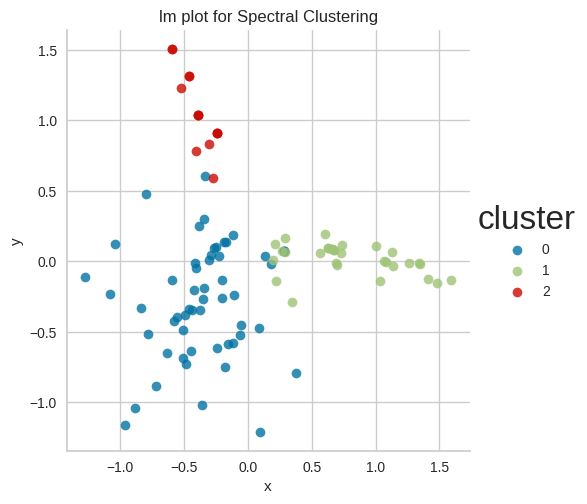

In [77]:
## plot spectral clustering
# set n_clusters = 3 to directly compare with Kmeans and PCA clusters of 3 above
spectral = SpectralClustering(n_clusters=3, random_state = 42).fit(x_cols)

labels = spectral.labels_
df['cluster'] = labels
sil_score = sklearn.metrics.silhouette_score(x_cols, labels, metric='sqeuclidean')
print('Silhouette Coefficient: {}'.format(sil_score))


sns.lmplot(x='x', y='y', hue='cluster', data=df, fit_reg=False).set(title="lm plot for Spectral Clustering")
plt.show();

Summary:
* The optimal silhouette coefficient is 0.148 with 3 clusters. This plot actually looks similar to our PCA plot for K=3 above.
* We can alos see the Optimized number of clusters is: 10, with a silhouette score of: 0.109

## Spectral Clustering Method Comparison
* There are different spectral clustering methods.
* Above we essentially use the default parameters in sklearn. Here we can try 2 other methods that look at changes in the affinity matrix.
* The affinity metric determines how close, or similar, two points our in space. We will change the paramter "affinity and test for:
1. Gaussian Kernel (rbf)
2. standard Euclidean metric (neaerest neighbors)



### RBF or Gaussian Spectral Clustering

In [79]:
#rbf or gaussian spectral clustering
# Building the clustering model
spectral_model_rbf = SpectralClustering(n_clusters = 3, affinity ='rbf',random_state=42)

# Training the model and Storing the predicted cluster labels
labels_rbf = spectral_model_rbf.fit_predict(pca_features)

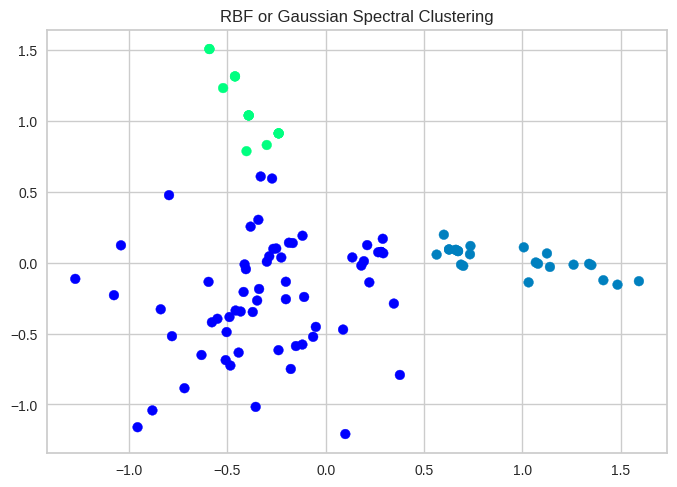

In [84]:
# Visualizing the clustering
plt.scatter(pivot_df['x'], pivot_df['y'],
           c = SpectralClustering(n_clusters = 3, affinity ='rbf') .fit_predict(pca_features), cmap =plt.cm.winter)
plt.title("RBF or Gaussian Spectral Clustering")
plt.show()

### Nearest Neighbors or Euclidean Spectral Clustering

In [81]:
# Building the clustering model
spectral_model_nn = SpectralClustering(n_clusters = 3, affinity ='nearest_neighbors',random_state=42)

# Training the model and Storing the predicted cluster labels
labels_nn = spectral_model_nn.fit_predict(pca_features)

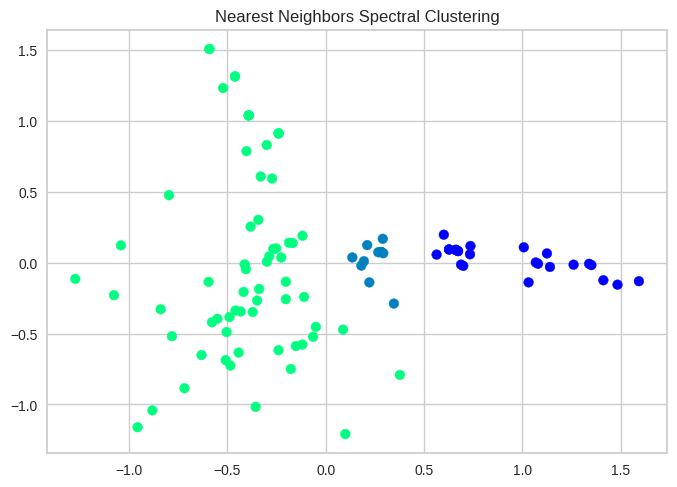

In [83]:
# Visualizing the clustering
plt.scatter(pivot_df['x'], pivot_df['y'],
           c = SpectralClustering(n_clusters = 3, affinity ='nearest_neighbors') .fit_predict(pca_features), cmap =plt.cm.winter)
plt.title("Nearest Neighbors Spectral Clustering")
plt.show()

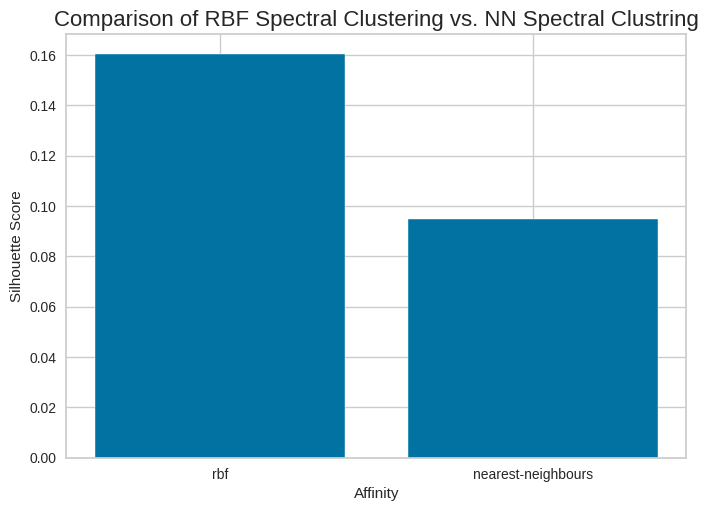

The silhouette score for RBF Spectral Clustering is: 0.1602424827181591
The silhouette score for NN Spectral Clustring is: 0.0948592879590902


In [97]:
## List of different values of affinity
affinity = ['rbf', 'nearest-neighbours']

# List of Silhouette Scores
s_scores = []

# Evaluating the performance
s_scores.append(sklearn.metrics.silhouette_score(pivot_df, labels_rbf))
s_scores.append(sklearn.metrics.silhouette_score(pivot_df, labels_nn))

# Plotting a Bar Graph to compare the models
plt.bar(affinity, s_scores)
plt.xlabel('Affinity')
plt.ylabel('Silhouette Score')
plt.title('Comparison of RBF Spectral Clustering vs. NN Spectral Clustring',fontsize=16)
plt.show()

print(f"The silhouette score for RBF Spectral Clustering is: {s_scores[0]}")
print(f"The silhouette score for NN Spectral Clustring is: {s_scores[1]}")

# append the silhouette scores to the final dictionary
cluster_dict["Spectral - RBF"] = s_scores[0]
cluster_dict["Spectral - NN"] = s_scores[1]

Summary of 2 Spectral Clustering Methods:
* We can see the silhouette score for RBF is higher at 0.16 than for NN which was 0.09.

#3. Agglomerative Clustering
* Commonly called "bottom-up" clustering, becuase all data points are treated as individual clusters to start the process and gradually as the bottom-up process continues become larger clusters.
* Every data point is independent at the start -> then mege 2 clusters at a time. The "decision" to merge 2 clusters is based on the pairwise distance between 2 clusters picked with a minimum distance between.
* There are various methods used to measure the pairwise distance:
1. Wards - merges 2 clusters based on the change in which the total variation is minimized.
2. Complete - "complete-link" clustering. Equation: `D(t,k) = max(D(r,k),D(s,k))`
    * `D(t,k)` is the MAX distance between to points in a cluster which are t and k.
3. Average - there are 2 cases in this method. The "unweighted" and "weighted".
    * Unweighted average: number of points in a cluster r and num of points in cluster s are merged into 1 cluster. The percent of points in the 2 component clusters (r and s) are computed with respect the whole.
    * Weighted average: the arithemetic mean is used instead of the proportion of percentage of the parts of the cluster.
4. Single - "single-link" clustering. Equation: `D(t,k) = min(D(r,k),D(s,k))`
    * `D(t,k)` is the MIN distance between 2 points in a cluster t and k.

* Source for above: https://online.stat.psu.edu/stat508/lesson/12/12.6


* For the Agglomerative Clustering below we need to tune the hyperparameter "linkage" as this is the param in sklearn that determines which distance to use between sets of observation. The algorithm will merge the pairs of cluster that minimize this criterion.



In [88]:
from sklearn.cluster import AgglomerativeClustering

# Hyperparameter Tuning
merge_strategy = ['ward', 'complete', 'average', 'single']

# Use n_clusters = 3 for agglomerative clustering
best_score = 0

for i in range(len(merge_strategy)):
    linkage = merge_strategy[i]  # define the strategy

    ac = AgglomerativeClustering(n_clusters=3, linkage=linkage)
    ac_cluster = ac.fit_predict(x_cols)
    sil_avg_score = sklearn.metrics.silhouette_score(x_cols, ac_cluster, random_state = 42)

    print("For k=3 and linkage method: '{}', the silhouette score is: {:0.3f}".format(linkage, sil_avg_score))
    if sil_avg_score > best_score:
        best_score = sil_avg_score  # Update with the best silhouette score
        optimal_strategy = linkage

print("\nOptimized merge strategy is: '{}', with a silhouette score of: {:0.3f}".format(optimal_strategy, best_score))
# append the silhouette scores to the final dictionary
cluster_dict["Agglomerative"] = best_score

For k=3 and linkage method: 'ward', the silhouette score is: 0.116
For k=3 and linkage method: 'complete', the silhouette score is: 0.056
For k=3 and linkage method: 'average', the silhouette score is: 0.190
For k=3 and linkage method: 'single', the silhouette score is: 0.171

Optimized merge strategy is: 'average', with a silhouette score of: 0.190


Silhouette Coefficient: 0.1734505160934133


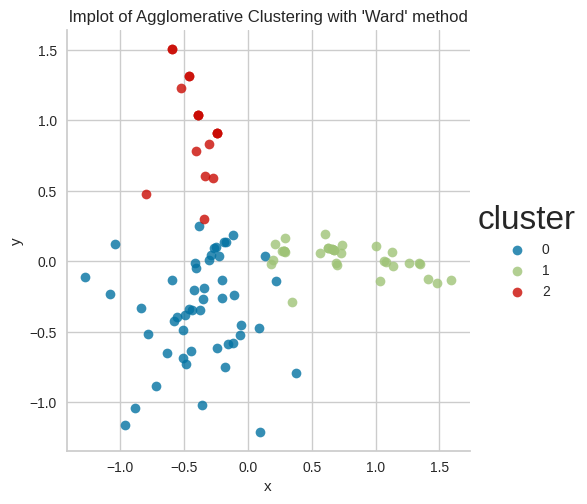

In [93]:
## we will plot the the agg clustering with wards
agc = AgglomerativeClustering(n_clusters = 3, linkage='ward').fit(x_cols)
labels= agc.labels_
df['cluster'] = labels
sil_score = sklearn.metrics.silhouette_score(x_cols, labels, metric='sqeuclidean')
print('Silhouette Coefficient: {}'.format(sil_score))

# seaborn lmplot
sns.lmplot(x='x', y='y', hue='cluster', data=df, fit_reg=False).set(title="lmplot of Agglomerative Clustering with 'Ward' method")
plt.show();


Summary:
* After testing out the 4 Agglomerative linkage methods, we did find the most optimal merged strategy was "average" with a silhouette score of 0.190. However, this did not produce the most optimal 3 clusters, the Ward stategy did which is plotted above (I tested all of them). This makes sense since the Ward method attempts to form clusters based on minimizing the total varation and the total variation of a clustering merge is the sum of squares between every data point and the centroid of the cluster. Sound familiar? The sum of squares is what we used in the kmeans elbow method.

#4. DBSCAN
* Density-based spatial clustering of applications with noise (DBSCAN) is a clustering algorithm used in machine learning to divide data into clusters based on their distance to other points.
* It is quite effective at identifying and removing noise in a dataset, making it useful for data cleaning and outlier detection.
* The algorithm works by partitioning data points into dense regions of data points that are separated by less dense data points.
    * Clusters are areas of the dataset where points lie close to one another.
    * Outliers or noise are areas where points are furthest from a cluster.
* The radius or "Epsilon" (ϵ) is the first parameter we need to tune to make this work. This is the maximum distance between two points for them to be considered neighbors. Points that are within eps distance of each other are considered part of the same cluster.
* The parameter "min_samples" is important as it is the minimum number of points required for a point to be considered a core point. Points that have fewer than min_samples neighbors are labeled as noise. We can tune this param but we are working with a fixed default of 3 based on our comparison algorithms above.
* Source: https://builtin.com/articles/dbscan

In [94]:
from sklearn.cluster import DBSCAN

# Hyperparameter Tuning
eps_list = np.linspace(0.1, 2 , 10, endpoint=False) # # Returns 10 values for eps # default eps is 0.5

# Tune min_samples for DBSCAN
# min_samples = [1, 2, 3]

best_score = 0

for s in eps_list:

    db = DBSCAN(eps=s, min_samples=3)
    db_cluster = db.fit_predict(x_cols)
    sil_avg_score = sklearn.metrics.silhouette_score(x_cols, db_cluster, random_state = 42)

    print("For eps: '{:0.2f}', the silhouette score is: {:0.3f}".format(s, sil_avg_score))
    if sil_avg_score > best_score:
        best_score = sil_avg_score  # Update with the best silhouette score
        optimal_eps = s

print("\nBest eps value is: '{:0.2f}', with a silhouette score of: {:0.3f}".format(optimal_eps, best_score))
# append the silhouette scores to the final dictionary
cluster_dict["DBSCAN"] = best_score

For eps: '0.10', the silhouette score is: -0.107
For eps: '0.29', the silhouette score is: -0.107
For eps: '0.48', the silhouette score is: -0.107
For eps: '0.67', the silhouette score is: -0.107
For eps: '0.86', the silhouette score is: -0.107
For eps: '1.05', the silhouette score is: 0.038
For eps: '1.24', the silhouette score is: 0.038
For eps: '1.43', the silhouette score is: 0.132
For eps: '1.62', the silhouette score is: 0.132
For eps: '1.81', the silhouette score is: 0.180

Best eps value is: '1.81', with a silhouette score of: 0.180


Silhouette Coefficient: 0.30658569565490695


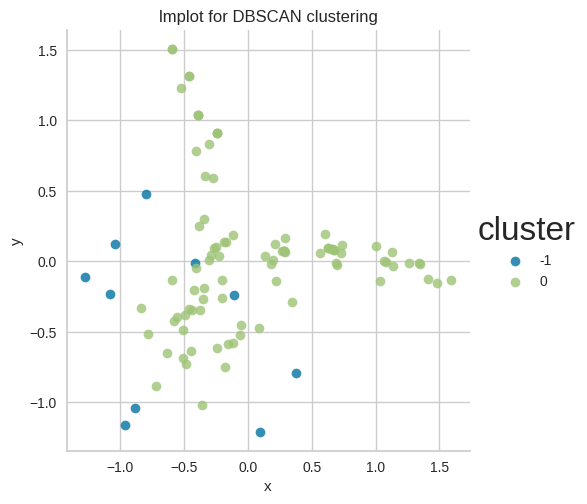

In [95]:
## plot DBSCAN based on the epsilon value above
dbscan = DBSCAN(min_samples=3, eps=1.81).fit(x_cols)
labels = dbscan.labels_
df['cluster'] = labels
sil_score = sklearn.metrics.silhouette_score(x_cols, labels, metric='sqeuclidean')
print('Silhouette Coefficient: {}'.format(sil_score))

# seaborn lmplot
sns.lmplot(x='x', y='y', hue='cluster', data=df, fit_reg=False).set(title="lmplot for DBSCAN clustering")
plt.show();

Summary:
* We will analyze below which algorithm was the best but based on the clustering result, it appears that the DBSCAN algorithm was not as successful at identifying the 3 clusters as the other algorithms.

# Final Analysis of the 4 algorithms
1. Affinity
2. Spectral
3. Agglomerative
4. DBSCAN

In [ ]:
## first I need to add the addti

In [98]:
# Make a dataframe from the cluster dictionary:
cluster_eval = pd.DataFrame(cluster_dict.items(), columns=['Algorithm', 'Best Silhouette Scores'])
cluster_eval.set_index('Algorithm', inplace=True)
cluster_eval

,Best Silhouette Scores
Algorithm,
Affinity,0.125711
Spectral,0.108942
Agglomerative,0.189874
DBSCAN,0.180204
Spectral - RBF,0.160242
Spectral - NN,0.094859


In [100]:
# Use orient = 'index' to use keys as index
cluster_eval = pd.DataFrame.from_dict(cluster_dict, orient='index', columns=['Best Silhouette Score'])
cluster_eval.sort_values(by="Best Silhouette Score", ascending=False)

,Best Silhouette Score
Agglomerative,0.189874
DBSCAN,0.180204
Spectral - RBF,0.160242
Affinity,0.125711
Spectral,0.108942
Spectral - NN,0.094859


# Summary of these clustering algorithms
* We can see that Agglomerative had the best Silhouette score followed by DBSCAN and Spectral RBF.
* Agglomerative likely had the best score because as we know it is commonly called "bottom-up" clustering, as all data points are treated as individual clusters to start the process and gradually as the bottom-up process continues become larger clusters. Since every data point is independent at the start of the clustering and then meged 2 clusters at a time. The "decision" to merge 2 clusters is based on the pairwise distance between 2 clusters picked with a minimum distance between. There are 4 metrics that we used to calculate the Agglomerative clustering silhouette: Wards, Average, Single and Complete. The best score was Average which is the unweighted or weighted average of the pairwise distances between point when merging a cluster. Although Wards did produce the best plot. Either way, I am not surprised this was the best algorithm because with our data as a lower number of clusters had more data points and more density thus the agglomerative method makes sense for finding the best pairwise distance between points.
* The 2nd highest was DBSCAN which again makes sense based on the density of our data.
* The 3rd highest was Spectral - RBF which is the radial basis kernel function based on the gaussian distribution rather than the affinity. The RBF kernel computes the similarity of X1 and X2 as the Euclidean L2 norm between these 2 points in space. This is more similar to the standard k-means clustering algorithm. Therefore I am not surprised that this was ranked higher than the last 3 algorithms (Affinity, Spectral, and Spectran nearest neighbors) which are more closer to the Kmeans clustering.
  * source: https://towardsdatascience.com/radial-basis-function-rbf-kernel-the-go-to-kernel-acf0d22c798a

# Final Summary
* This was an excellent exercise in Data Science clustering techniques and detailed analysis using PCA as a dimensionality reduction technique.
* Since a good portion of our findings were based off the PCA clustering technique which assumes the data is linear, we may want to consider looking at doing this analysis with t-SNE which is a nonlinear technique that focuses on preserving the pairwise similarities between data points in a lower-dimensional space. t-SNE is concerned with preserving small pairwise distances whereas, PCA focuses on maintaining large pairwise distances to maximize variance. This is a question I think we can answer based on our clusters, the data does not appear to be linear as a whole so t-SNE may show us additional information we don't already have (although perplexity can be a tricky hyperparameter to tune). But perhaps we can do this in another notebook at another time.
* It was interesting that we found the K=3 was optimal using PCA as well as The Calinski-Harabasz index (using the Yellowbrick API from sklearn) also known as the Variance Ratio Criterion, which is the ratio of the sum of between-clusters dispersion and of inter-cluster dispersion for all clusters, the higher the score, the better the performances. It is clear that there was a distinct relationship between the variance ratio and the PCA being able to maximize the variance in our data by maintaining the large pairwise data point differnces during dimensionality reduction in our data which the PCA and Calinski-Harabasz was able to decipher for us.
* Lastly, it was also interesting that the Agglomerative clustering algorithm had the best silhouette score out of the final 4 algorithms. Again this algorithm focuses on the pairwise distances within a cluster when constructing a bottom-up cluster, thus I think this summarizes that the pairwise distance in our data was an important feature based on the density of our clusters which helped us to be able to find a K of 3 and thus find 3 distinct customer groups.
* Finally, for our stakeholders, lets not forget our findings with the Wine data from our 3 customer groups!
1. The Pinot Noir was most popular among group 3.
2. French wine was most popular among groups 1 and 2.
3. The regions that were most popular for group 3 which had the highest affinity for Pinot Noir were New Zealand, Italy and France. Perhaps it might be useful for our business to look further into the Pinot Noir from these regions since it is so popular among group 3.
4. Also let us not forget that group 1 signifanctly preferred Pinot Noir over other wine types and they also preferred wine from France more than any other group, so we should absolutely consider looking at French Pinot Noir wine as well.